## Predicting point positions in a frame 
The code is reproduced and adjusted from https://dmol.pub/ Chapter: "19. Equivariant Neural Network for Predicting Trajectories."

The purpose of this exercise is to predict the position of points in a frame based on a previous frame with a simple single perceptron model and then compare it with an e3nn equivariant modoel.   

I created the baseline model with torch instead of writing it from scratch as done in the tutorial and am getting slighlty better results. That's probably because pytorch uses more efficient operations under the hood, for example the initial weights are small and normally distributed instead of 0, which likely results in better training. 

The prediction improves as expected with the the number of epochs and higher number of frames (e.g. prediction of frame 100 better than prediction of frame 10). The prediction though are not invariant or equivariant to the input. 
That means if we were to change the input coordinates to shift all the points along an axis, the model would give us a wrong point prediction for the next frame. 

In [1]:
import torch
from torch import nn
import torch_geometric
import e3nn
import matplotlib.pyplot as plt
import urllib.request
import numpy as np

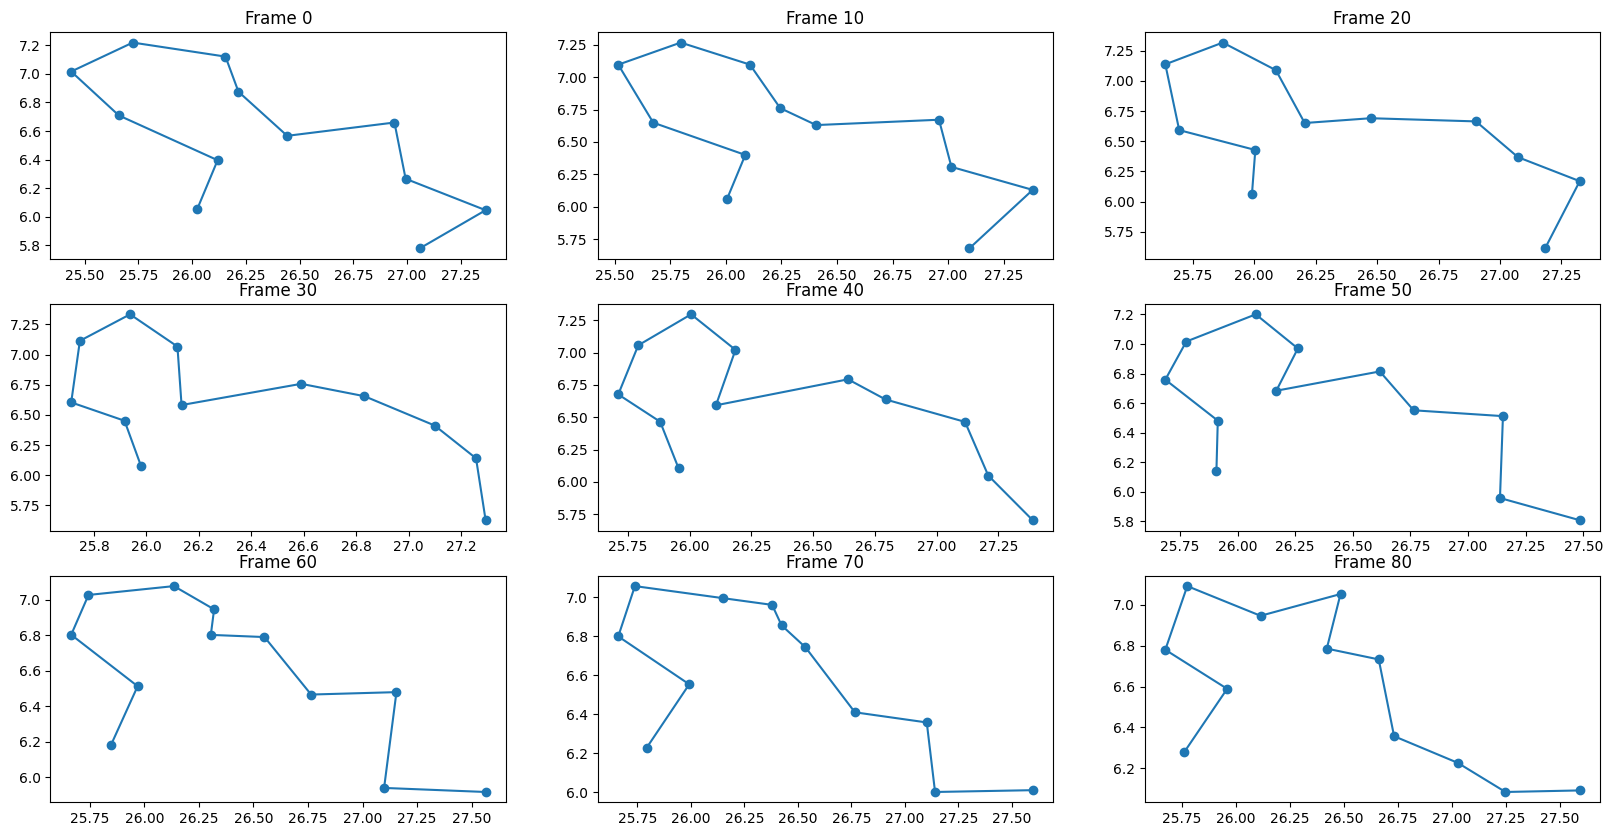

In [2]:
# load dataset
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/main/data/paths.npz", "../data/paths.npz"
)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
paths = np.load("../data/paths.npz")["arr"]

# plot the first n frames
frame = 0
for row in range(3):
    for col in range(3):
        plt.title("First Frame")
        axs[row, col].set_title(f"Frame {frame}")
        axs[row, col].plot(paths[frame, :, 0], paths[frame, :, 1], "o-")
        frame += 10

plt.show();

In [3]:
# since I will be using e3nn later, which works with 3D inputs I need to add a third z dimension to the 
# coordinates for each point in the training set. The baseline model can work with 2D coordinates, but this way
# the input feature (dimension) is the same across both models.

n_frames = paths.shape[0] 
n_points = paths.shape[1]

traj_3d = np.array([])
for i in range(n_frames):
    for j in range(n_points):
        TBA = paths[i][j]
        TBA = np.append(TBA, np.array([0.00]))
        traj_3d = np.append(traj_3d, TBA)

traj_3d = traj_3d.reshape(n_frames, n_points, 3)

In [4]:
# input features are all points in a frame, labels are all points in the following frame. 
features = traj_3d[:-1]
labels = traj_3d[1:]
print(features.shape)

# create dataset, with 80-20 split
train_split = int(len(features)  * 0.80) 
training_set = features[:train_split]
training_labels = labels[:train_split]
valid_set = features[train_split:]
valid_labels = labels[train_split:]

(2047, 12, 3)


success! frames match!


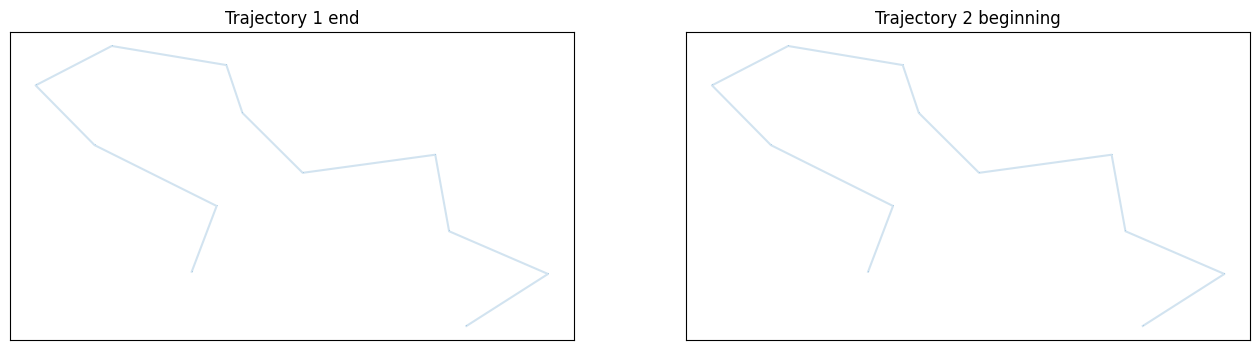

In [5]:
# mean squared error loss function. Helper function to test that frame 1 in training set matches frame 0 in label set.
def mse(y, yhat):
    return np.mean((yhat - y) ** 2)

if mse(features[1], labels[0]) == 0:
    print("success! frames match!")
else:
    print(mse(features[1], labels[0]))
    
fig, axs = plt.subplots(ncols=2, nrows=1, squeeze=True, figsize=(16, 4))
axs[0].set_title("Trajectory 1 end")
axs[1].set_title("Trajectory 2 beginning")

for i in range(0, 1, 1):
    axs[0].plot(features[i, :, 0], features[i, :, 1], ",-", alpha=0.2)
    axs[1].plot(labels[i, :, 0], labels[i, :, 1], ",-", alpha=0.2)   
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [6]:
# create baseline model
class BaseLineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3, 3)
        
    def forward(self, x):
        logits = self.lin1(x)
        return logits
        
model = BaseLineModel()

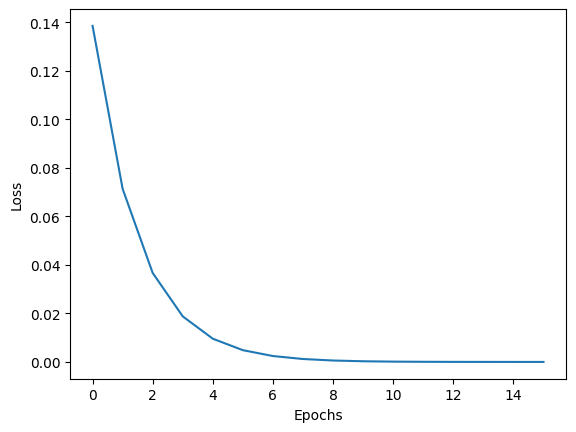

In [7]:
# training
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 16

def train(x, y, model, loss_fn, optimizer):
    model.train()
    
    # forward pass
    logits = model(x)
    
    # loss
    loss = loss_fn(logits, y)
    
    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), logits
    
    
def validation(x, y, model, loss_fn):
    model.eval()
    
    # forward pass
    logits = model(x)
    
    # loss
    loss = loss_fn(logits, y)
    return logits


baseline_train_loss = []
yst = []
y_hats = []

for epoch in range(epochs):
    for frame in range(1637):
        inputs = torch.tensor(training_set[frame]).to(torch.float32) # input data need to match weights dtype torch.float32
        labels = torch.tensor(training_labels[frame]).to(torch.float32)
        loss, y_hat = train(inputs, labels, model, loss_fn, optimizer)
        if frame % 10 == 0:
            yst.append(labels)
            y_hats.append(y_hat.detach().numpy())
        
    if epoch % 1 == 0:
        baseline_train_loss.append(loss)
    
plt.plot(baseline_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

[28.48233  28.03168  27.973103 28.270596 28.08258  28.299929 28.548914
 28.904873 28.717833 29.34983  29.478893 29.065592]


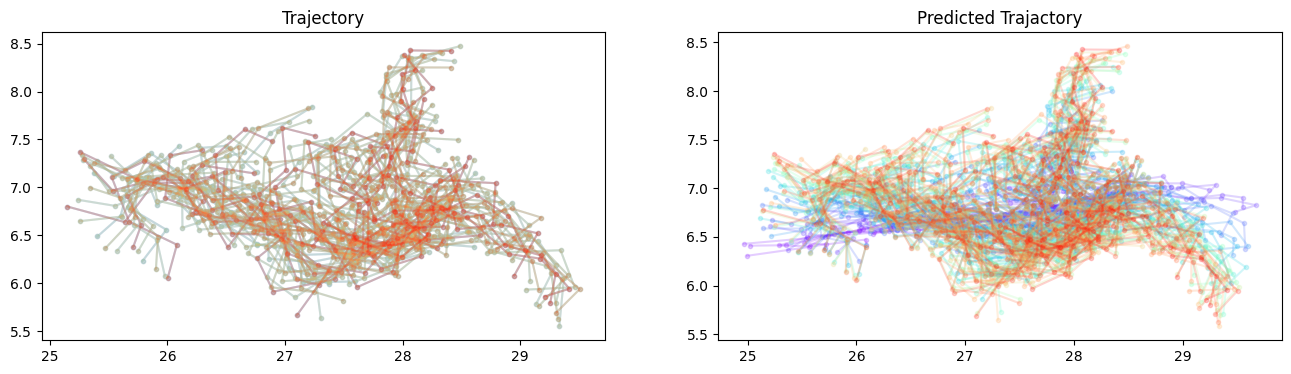

In [8]:
# comparing trajectory vs predition
fig, axs = plt.subplots(ncols=2, squeeze=True, figsize=(16, 4))

y_st = np.stack(yst, axis=0)
y_hat = np.stack(y_hats, axis=0)

print(y_hat[1639, :, 0])
axs[0].set_title("Trajectory")
axs[1].set_title("Predicted Trajactory")

cmap = plt.get_cmap("rainbow")
for i in range(1, y_st.shape[0], 10):
    axs[0].plot(
        y_st[i, :, 0], y_st[i, :, 1], ".-", alpha=0.2, color=cmap(i / y_st.shape[0])
    )
    axs[1].plot(
        y_hat[i, :, 0], y_hat[i, :, 1], ".-", alpha=0.2, color=cmap(i / y_st.shape[0])
    )